<a href="https://colab.research.google.com/github/pachterlab/JBMMCKP_2023/blob/main/notebooks/cdx_cerebellum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

connect to R runtime above with `Runtime > Change Runtime Type`

Load  `concordexR` and some extra libraries for plotting and utility functions.

In [ ]:
system("git clone https://github.com/pachterlab/JBMMCKP_2023.git")
setwd("JBMMCKP_2023")

Install `magick` and `fastcluster` on Colab

In [ ]:
# Installation of  `magick` is req'd for some BioC packages,
# but installation is halted on Colab
system('add-apt-repository -y ppa:cran/imagemagick')
system('apt-get update')
system("apt-get install libmagick++-dev")
system("sudo apt-get install libgmp-dev")

install.packages("magick")
install.packages("fastcluster")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Install Bioconductor packages

In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.19")

# Install Bioconductor packages
BiocManager::install("SpatialExperiment")
BiocManager::install("bluster")
BiocManager::install("scater")
BiocManager::install("mbkmeans")

In [ ]:
 devtools::install_github("pachterlab/concordexR")

In [ ]:
library(fs)
library(readr)

library(purrr)
library(ggplot2)

library(scuttle)
library(scater)

library(concordexR)

data_dir <- fs::path("data/cerebellum/")

Data obtained from [here](https://singlecell.broadinstitute.org/single_cell/study/SCP948/robust-decomposition-of-cell-type-mixtures-in-spatial-transcriptomics). "Filtered" dataset is one with "Reject" cells removed.

In [ ]:
counts <- read_csv(fs::path(data_dir, "cerebellum_counts_filtered.csv"))
coords <- read_csv(fs::path(data_dir, "cerebellum_coords.csv"), col_names=FALSE)
names(coords) <- c("x","y")

# cell type assignments
assignments <- read_csv(fs::path(data_dir, "cell_assignments_filtered.csv"))
assignments <- assignments$first_type

Process data and perform PCA

In [ ]:
norm_counts <- normalizeCounts(counts, transform="log")
pca <- calculatePCA(norm_counts) # Columns are cells/spots

Now, compute concordex neighborhood consolidation matrix with cell type labels (discrete). Identify SHRs by providing a bluster clustering parameters object to the `BLUSPARAM` argument.

In [ ]:
# defaults to 30 nn
set.seed(5296)

cdx_discrete <- calculateConcordex(
    x=coords,
    labels=assignments,
    BLUSPARAM=bluster::MbkmeansParam(4,50))

cdx_pred <- attr(cdx_discrete, "shrs")
pl_data <- dplyr::mutate(coords, shr=cdx_pred)

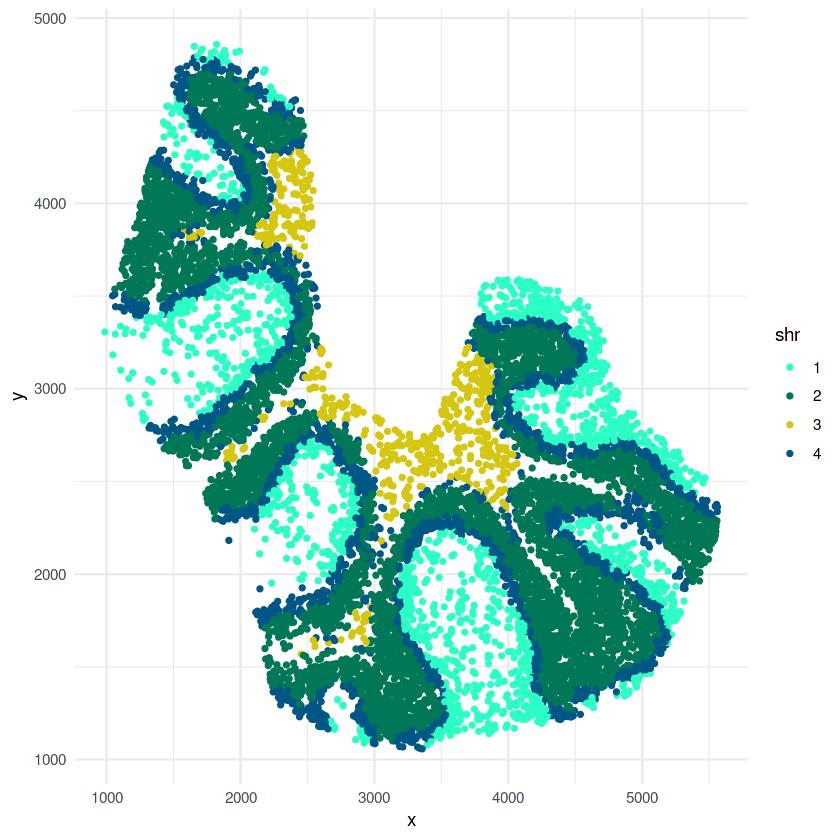

In [ ]:
p <- ggplot(pl_data, aes(x, y, color=shr)) +
    geom_point(size=1) +
    theme_minimal() +
    scale_color_manual(values=c("#2CFFC6","#007756","#D5C711","#005685"))

p

Now, visualize the NbC matrix as a heatmap for the disrete labels

In [ ]:
# Sort rows of neighborhood matrix for plotting
hc <- fastcluster::hclust.vector(cdx_discrete, method='single')
heat_data <- data.frame(hc_order=hc$order, sort_order=seq(nrow(cdx_discrete)))
heat_data <- arrange(heat_data, hc_order)

# Not ideal, but make cdx results dense
heat_data <- cbind(heat_data, pl_data, as.matrix(cdx_discrete))
heat_data <- arrange(heat_data, sort_order)

heat_data$hc_order <- factor(heat_data$hc_order, levels=unique(heat_data$hc_order))


Tidy data for heatmap

In [ ]:
layer_order <- c("OL","GL","PBL","ML")

heat_data <- heat_data |>
    pivot_longer(-c(hc_order, sort_order, x, y, shr)) |>
    mutate(
        shr_pretty = case_when(
            shr == "1" ~ "ML",
            shr == "3" ~ "OL",
            shr == "2" ~ "GL",
            TRUE ~ "PBL"),
        shr_pretty = factor(shr_pretty, levels=layer_order))

Plot heatmap

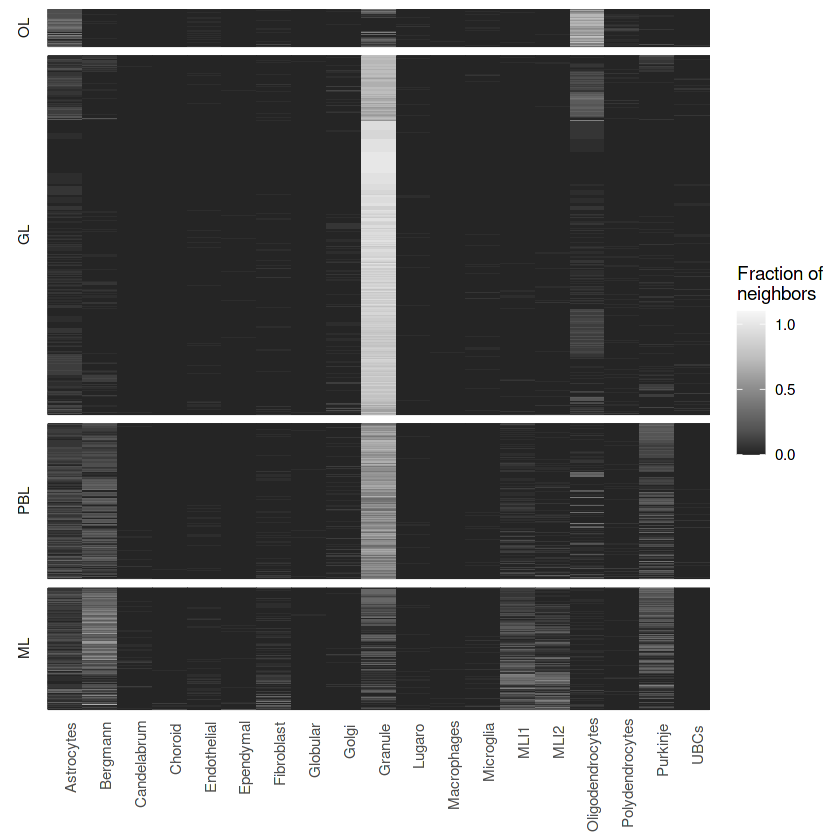

In [ ]:
p <- ggplot(heat_data, aes(x=name, y=hc_order)) +
    geom_tile(aes(fill=value),linewidth=0) +
    facet_grid(rows=vars(shr_pretty), scales='free_y',space='free_y', switch="y") +
    labs(fill = "Fraction of\nneighbors") +
    scale_x_discrete(expand=expansion(add=0)) +
    scale_fill_distiller(
        palette="Greys",
        limits=c(0, 1.1),
        breaks=c(0,0.5,1)) +
    theme_minimal() +
    theme(
        axis.title=element_blank(),
        axis.text.y=element_blank(),
        axis.text.x=element_text(angle=90, hjust=0.9),
        strip.placement="outside",
    )

p

In [ ]:
# defaults to 30 nn
set.seed(5296)

cdx_contin <- calculateConcordex(
    x=coords,
    labels=pca,
    BLUSPARAM=bluster::MbkmeansParam(4,50))

cdx_pred <- attr(cdx_contin, "shrs")
pl_data <- dplyr::mutate(coords, shr=cdx_pred)

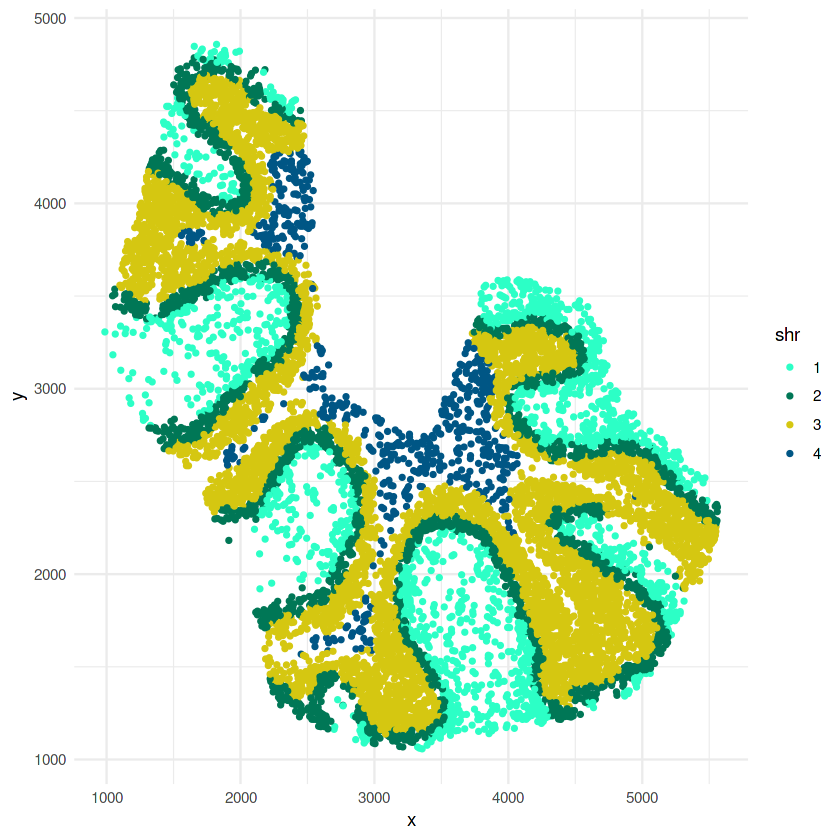

In [ ]:
p <- ggplot(pl_data, aes(x, y, color=shr)) +
    geom_point(size=1) +
    theme_minimal() +
    scale_color_manual(values=c("#2CFFC6","#007756","#D5C711","#005685"))

p

In [ ]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] concordexR_0.99.3           scater_1.32.0              
 [3] scuttle_1.14.0              SingleCellExperiment_1.26.0
 [5] SummarizedExperiment_1.34.0 Biobase_2.